In [8]:
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

""" Custom modules """
sys.path.append('lib') # All custom modules are in the lib folder

from hogfeatures import HogFeatureUtil
from imageutil import ImageUtil
from videoutil import VideoUtil

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the get_hog_feature method of the HogFeatureUtil class (lib/hogfeatures.py). It uses the following parameters:
- orient = 9
- pix_per_cell = 8
- cell_per_block = 2

I prepared the training images in the following folder structure.
- vehicles:
    - images/vehicles/GTI_Far
    - images/vehicles/GTI_Left
    - images/vehicles/GTI_MiddleClose
    - images/vehicles/GTI_Right
    - images/vehicles/KITTI_extracted
- non-vehicles:
    - images/non-vehicles/Extras
    - images/non-vehicles/GTI

In [2]:
cars, notcars = ImageUtil.load_cars_notcars_images()

In [3]:
""" Visualization and Validation """
def random_img(arr):
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(arr))
    # Read in the image
    img = mpimg.imread(arr[ind])
    return img

def test_random_car_and_notcar(cars, notcars):
    
    car_img = random_img(cars)
    notcar_img = random_img(notcars)

    fig = plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(car_img)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_img)
    plt.title('Example None-Car Image')
    
def test_random_hog(arr):
    img = random_img(arr)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    features, hog_img = HogFeatureUtil.get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    return img, hog_img    

def test_hog_random_car_and_notcar(cars, notcars, n=1):
    
    for _ in range(0, n):
        car_img, car_hog_img = test_random_hog(cars)
        notcar_img, notcar_hog_img = test_random_hog(notcars)

        # Plot the examples|
        fig = plt.figure(figsize=(20,20))
        plt.subplot(141)
        plt.imshow(car_img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(142)
        plt.imshow(car_hog_img, cmap='gray')
        plt.title('HOG Visualization')
        plt.subplot(143)
        plt.imshow(notcar_img, cmap='gray')
        plt.title('Example None-Car Image')
        plt.subplot(144)
        plt.imshow(notcar_hog_img, cmap='gray')
        plt.title('HOG Visualization')    

8792 8968


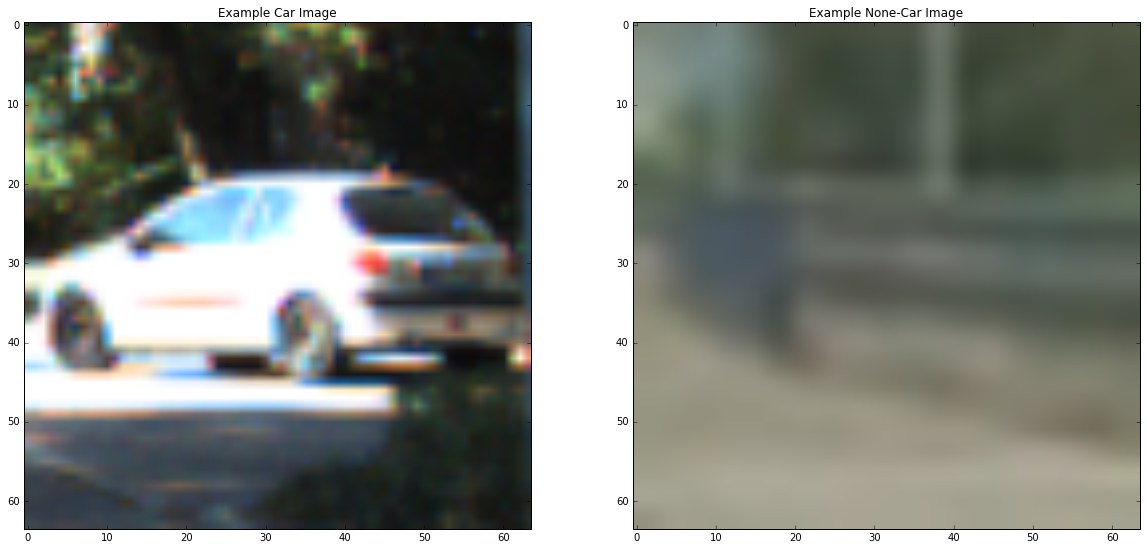

In [4]:
print(len(cars), len(notcars))
test_random_car_and_notcar(cars, notcars)

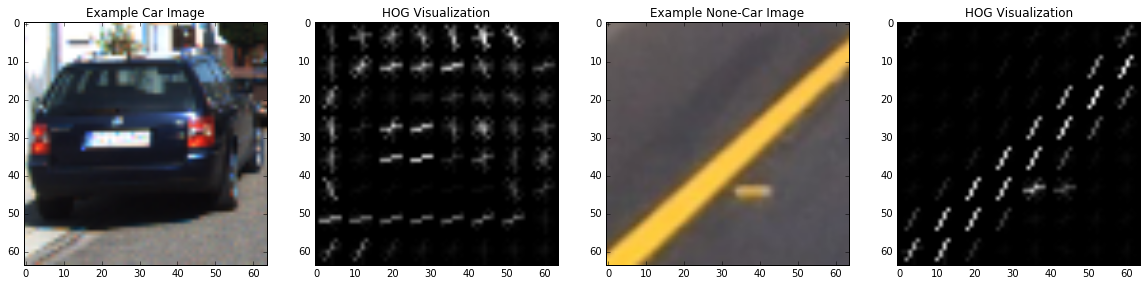

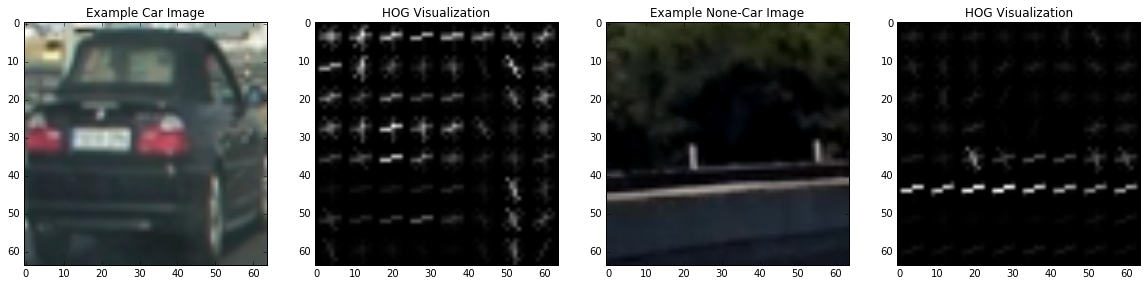

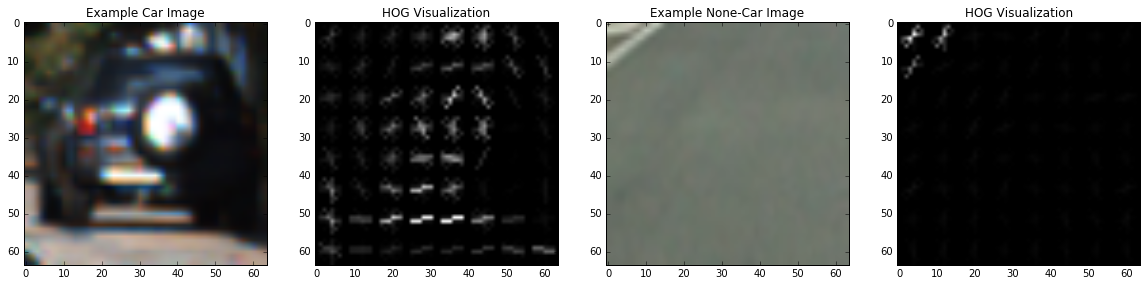

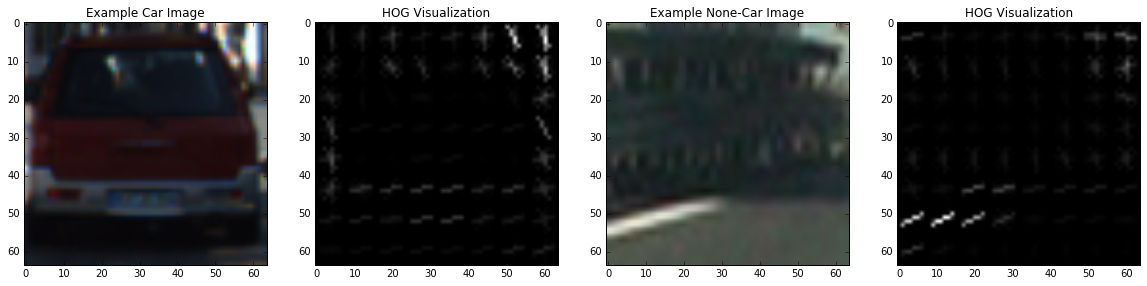

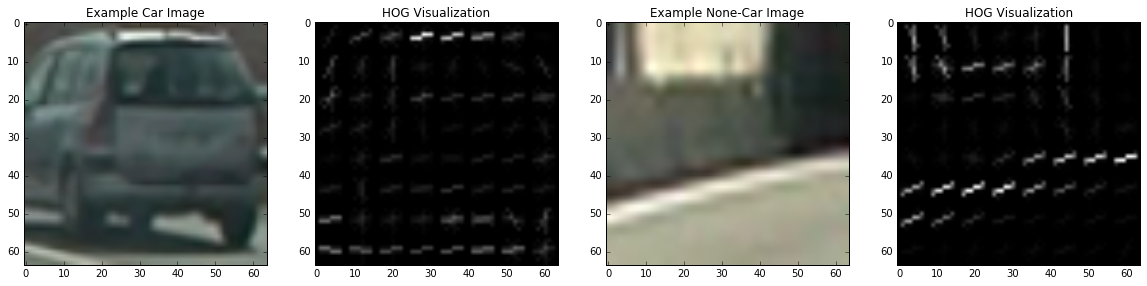

In [6]:

test_hog_random_car_and_notcar(cars, notcars, 5)

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

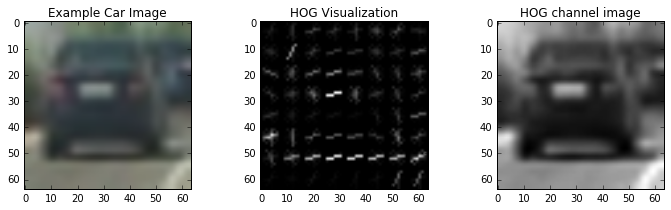

In [5]:
@interact
def test_hog(cars=fixed(cars), i:(0, len(cars))=0, orient:(0,32)=9, pix_per_cell:(8,24)=8, cell_per_block:(1,4) = 2):
  
    img = mpimg.imread(cars[i])    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    features, hog_img = HogFeatureUtil.get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

#     hif = HogImageFeatures(ycrcb[:, :, 0], orient, pix_per_cell, cell_per_block)
#     hifw=hif.window_hog_features(((0,0),(64,64)))
    #print(hifw)
    #assert (hif.features.values == hifw.features.values).all()
    #print(hif.features)
    # Plot the examples
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Example Car Image')
    plt.subplot(132)
    plt.imshow(hog_img, cmap='gray')
    plt.title('HOG Visualization')
    plt.subplot(133)
    plt.imshow(gray, cmap='gray')
    plt.title('HOG channel image')

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

In [9]:
X_scalar = HogFeatureUtil.hog_classify(cars, notcars)

4.11 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
0.15 Seconds to train SVC...
Test Accuracy of SVC =  0.995
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
0.00101 Seconds to predict 10 labels with SVC
